# Air Pollution Forecasting


# Many to One

*Autor: Juan Guerrero*

In [345]:
from keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D
from keras.models import Model, Sequential
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from math import sqrt

import pandas as pd
import numpy as np

In [346]:
LAG = 10
DELTA = 5

In [347]:
df = pd.read_csv('pollution_cdmx.csv', index_col=0)
df.head()

,cluster,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,PM10_var,longitud,latitud
0,0,2018-01-01,0.341621,5.354941,21.085771,26.458103,29.441700,61.780962,24.763505,46.634783,19.321739,52.458169,12.985310,275.528986,2.426877,508.824315,-99.152207,19.411617
1,0,2018-01-02,0.576061,29.640909,33.087121,62.752273,22.231692,44.550505,5.090909,25.012121,21.006818,54.553030,13.014015,181.011995,1.306692,594.083106,-99.152207,19.411617
2,0,2018-01-03,0.615833,34.652381,40.684524,75.279762,26.187500,65.009921,12.316468,36.572619,31.557143,49.047619,14.669742,185.158730,1.570933,232.192564,-99.152207,19.411617
3,0,2018-01-04,0.640831,34.725000,46.038889,80.816667,23.763889,72.472222,33.571759,46.741667,29.494444,55.414352,13.125231,147.268519,1.422454,357.724034,-99.152207,19.411617
4,0,2018-01-05,0.573737,23.072727,39.006061,62.080303,33.638258,67.153409,12.178030,39.697727,32.259848,44.804293,16.619066,169.859848,1.569255,234.366288,-99.152207,19.411617


In [348]:
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.dayofyear
df['weekday'] = df['date'].dt.dayofweek
df.head(2)

,cluster,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,PM10_var,longitud,latitud,day,weekday
0,0,2018-01-01,0.341621,5.354941,21.085771,26.458103,29.441700,61.780962,24.763505,46.634783,19.321739,52.458169,12.985310,275.528986,2.426877,508.824315,-99.152207,19.411617,1,0
1,0,2018-01-02,0.576061,29.640909,33.087121,62.752273,22.231692,44.550505,5.090909,25.012121,21.006818,54.553030,13.014015,181.011995,1.306692,594.083106,-99.152207,19.411617,2,1


In [349]:
l = list(df.columns)
l.remove('date')
l.remove('cluster')
l

['CO',
 'NO',
 'NO2',
 'NOX',
 'O3',
 'PM10',
 'SO2',
 'PM2.5',
 'PMCO',
 'RH',
 'TMP',
 'WDR',
 'WSP',
 'PM10_var',
 'longitud',
 'latitud',
 'day',
 'weekday']

In [350]:
for i in l:
  df[i] = df[i].astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13592 entries, 0 to 13591
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   cluster   13592 non-null  int64         
 1   date      13592 non-null  datetime64[ns]
 2   CO        13592 non-null  float64       
 3   NO        13592 non-null  float64       
 4   NO2       13592 non-null  float64       
 5   NOX       13592 non-null  float64       
 6   O3        13592 non-null  float64       
 7   PM10      13592 non-null  float64       
 8   SO2       13592 non-null  float64       
 9   PM2.5     13592 non-null  float64       
 10  PMCO      13592 non-null  float64       
 11  RH        13592 non-null  float64       
 12  TMP       13592 non-null  float64       
 13  WDR       13592 non-null  float64       
 14  WSP       13592 non-null  float64       
 15  PM10_var  13592 non-null  float64       
 16  longitud  13592 non-null  float64       
 17  latitud   13

In [351]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [352]:
df[l] = scaler.fit_transform(df[l])
df.head()

,cluster,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,PM10_var,longitud,latitud,day,weekday
0,0,2018-01-01,0.231607,0.048156,0.310870,0.181987,0.350751,0.311823,0.379338,0.415995,0.132108,0.520977,0.363008,0.771149,0.316997,0.011108,0.358743,0.401099,0.000000,0.000000
1,0,2018-01-02,0.390550,0.266555,0.505710,0.463555,0.263021,0.222268,0.077985,0.217145,0.144258,0.546090,0.364303,0.505652,0.154291,0.012969,0.358743,0.401099,0.002740,0.166667
2,0,2018-01-03,0.417514,0.311622,0.629053,0.560743,0.311155,0.328605,0.188669,0.323459,0.220331,0.480091,0.439026,0.517300,0.192671,0.005069,0.358743,0.401099,0.005479,0.333333
3,0,2018-01-04,0.434462,0.312275,0.715980,0.603698,0.281665,0.367390,0.514267,0.416977,0.205458,0.556416,0.369322,0.410867,0.171105,0.007809,0.358743,0.401099,0.008219,0.500000
4,0,2018-01-05,0.388974,0.207489,0.601803,0.458342,0.401813,0.339746,0.186548,0.352199,0.225398,0.429222,0.526998,0.474325,0.192428,0.005116,0.358743,0.401099,0.010959,0.666667


In [353]:
df[l].head()

,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,PM10_var,longitud,latitud,day,weekday
0,0.231607,0.048156,0.310870,0.181987,0.350751,0.311823,0.379338,0.415995,0.132108,0.520977,0.363008,0.771149,0.316997,0.011108,0.358743,0.401099,0.000000,0.000000
1,0.390550,0.266555,0.505710,0.463555,0.263021,0.222268,0.077985,0.217145,0.144258,0.546090,0.364303,0.505652,0.154291,0.012969,0.358743,0.401099,0.002740,0.166667
2,0.417514,0.311622,0.629053,0.560743,0.311155,0.328605,0.188669,0.323459,0.220331,0.480091,0.439026,0.517300,0.192671,0.005069,0.358743,0.401099,0.005479,0.333333
3,0.434462,0.312275,0.715980,0.603698,0.281665,0.367390,0.514267,0.416977,0.205458,0.556416,0.369322,0.410867,0.171105,0.007809,0.358743,0.401099,0.008219,0.500000
4,0.388974,0.207489,0.601803,0.458342,0.401813,0.339746,0.186548,0.352199,0.225398,0.429222,0.526998,0.474325,0.192428,0.005116,0.358743,0.401099,0.010959,0.666667


In [354]:
df_temp = pd.DataFrame()
df_temp[l] = scaler.inverse_transform(df[l])
df_temp

,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,PM10_var,longitud,latitud,day,weekday
0,0.341621,5.354941,21.085771,26.458103,29.441700,61.780962,24.763505,46.634783,19.321739,52.458169,12.985310,275.528986,2.426877,508.824315,-99.152207,19.411617,1.0,0.0
1,0.576061,29.640909,33.087121,62.752273,22.231692,44.550505,5.090909,25.012121,21.006818,54.553030,13.014015,181.011995,1.306692,594.083106,-99.152207,19.411617,2.0,1.0
2,0.615833,34.652381,40.684524,75.279762,26.187500,65.009921,12.316468,36.572619,31.557143,49.047619,14.669742,185.158730,1.570933,232.192564,-99.152207,19.411617,3.0,2.0
3,0.640831,34.725000,46.038889,80.816667,23.763889,72.472222,33.571759,46.741667,29.494444,55.414352,13.125231,147.268519,1.422454,357.724034,-99.152207,19.411617,4.0,3.0
4,0.573737,23.072727,39.006061,62.080303,33.638258,67.153409,12.178030,39.697727,32.259848,44.804293,16.619066,169.859848,1.569255,234.366288,-99.152207,19.411617,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13587,0.275000,7.541667,10.625000,18.166667,25.708333,37.276773,1.583333,21.833333,17.508955,51.333333,17.175000,149.416667,3.212500,483.309910,-98.902853,19.460415,116.0,1.0
13588,0.200000,4.666667,7.958333,12.666667,32.958333,24.289615,1.083333,12.708333,12.523864,54.958333,16.858333,211.333333,2.300000,146.434540,-98.902853,19.460415,117.0,2.0
13589,0.408333,14.208333,11.958333,26.250000,41.458333,31.989910,2.291667,20.708333,11.220328,55.625000,18.612500,177.250000,1.983333,292.650621,-98.902853,19.460415,118.0,3.0
13590,0.386957,9.434783,14.260870,23.695652,47.434783,34.238202,1.608696,19.913043,13.343750,56.478261,18.908696,138.913043,1.878261,265.474710,-98.902853,19.460415,119.0,4.0


In [355]:
x_one_time_cols = ['longitud', 'latitud', 'day', 'weekday']

In [356]:
col_order = list(df.columns)
x_cols = sorted(
    list({col for col in df.columns}.difference(['date', 'PM10', 'cluster'] + x_one_time_cols )),
    key=lambda x: col_order.index(x)
)
x_cols

['CO',
 'NO',
 'NO2',
 'NOX',
 'O3',
 'SO2',
 'PM2.5',
 'PMCO',
 'RH',
 'TMP',
 'WDR',
 'WSP',
 'PM10_var']

#### Representar serie de tiempo en una fila

In [357]:
def get_subdataframe(df: pd.DataFrame, cluster):
  return df[df.cluster == cluster].sort_values(by='date')

In [358]:
def join_prev_days(df: pd.DataFrame, lag: int, delta: int):
  df = df.copy()
  x_cols_t = []
  for i in range(lag, delta, -1):
    for x in x_cols:
      name = f't-{i}_{x}'
      df[name] = df[x].shift(i)
      x_cols_t.append(name)
  df = df[LAG:]
  return df

In [359]:
def get_x_cols_t(lag: int, delta: int):
  x_cols_t = []
  for i in range(lag, delta, -1):
    for x in x_cols:
      name = f't-{i}_{x}'
      x_cols_t.append(name)
  return x_cols_t

In [360]:
clusters = df['cluster'].unique()
x_cols_t = get_x_cols_t(LAG, DELTA)
dfs = {clusters[i]: join_prev_days(get_subdataframe(df, i), LAG, DELTA) for i in clusters}

In [361]:
df = dfs[clusters[0]]
for c in clusters[1:]:
  df = df.append(dfs[c])
df

,cluster,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,...,t-6_NOX,t-6_O3,t-6_SO2,t-6_PM2.5,t-6_PMCO,t-6_RH,t-6_TMP,t-6_WDR,t-6_WSP,t-6_PM10_var
10,0,2018-01-11,0.652870,0.387121,0.880438,0.746172,0.353673,0.396714,0.084381,0.400837,...,0.458342,0.401813,0.186548,0.352199,0.225398,0.429222,0.526998,0.474325,0.192428,0.005116
11,0,2018-01-12,0.387006,0.203088,0.615234,0.460758,0.333107,0.254851,0.131909,0.235886,...,0.450296,0.344417,0.110825,0.277076,0.181756,0.440284,0.431739,0.610791,0.215826,0.006260
12,0,2018-01-13,0.348870,0.371253,0.603599,0.601047,0.234244,0.315271,0.336899,0.252056,...,0.443238,0.360586,0.116484,0.243703,0.149737,0.363969,0.415726,0.413487,0.138592,0.010564
13,0,2018-01-14,0.169492,0.096148,0.421227,0.275537,0.256248,0.212405,0.349984,0.248148,...,0.701052,0.252766,0.078956,0.265444,0.241566,0.402174,0.421012,0.525936,0.241880,0.013739
14,0,2018-01-15,0.468456,0.405950,0.737130,0.693626,0.214979,0.298091,0.339878,0.291984,...,0.719730,0.198799,0.218305,0.274764,0.208103,0.360398,0.377241,0.615255,0.162852,0.009310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13587,8,2022-04-26,0.186441,0.067821,0.141040,0.117662,0.305324,0.184463,0.024254,0.187912,...,0.120895,0.532455,0.024254,0.165687,0.093245,0.484515,0.664912,0.460206,0.299778,0.006386
13588,8,2022-04-27,0.135593,0.041966,0.097747,0.074994,0.393540,0.116963,0.016595,0.103995,...,0.164856,0.499501,0.026169,0.205538,0.116795,0.490010,0.689545,0.471325,0.297962,0.007963
13589,8,2022-04-28,0.276836,0.127773,0.162687,0.180372,0.496966,0.156985,0.035105,0.177566,...,0.075963,0.506599,0.015957,0.111276,0.059011,0.556444,0.611884,0.573619,0.379665,0.002752
13590,8,2022-04-29,0.262343,0.084845,0.200068,0.160556,0.569686,0.168670,0.024643,0.170252,...,0.247285,0.395568,0.028722,0.180248,0.104567,0.476523,0.645920,0.527739,0.251967,0.003358


In [362]:
clusters

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [363]:
df.columns

Index(['cluster', 'date', 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'SO2',
       'PM2.5', 'PMCO', 'RH', 'TMP', 'WDR', 'WSP', 'PM10_var', 'longitud',
       'latitud', 'day', 'weekday', 't-10_CO', 't-10_NO', 't-10_NO2',
       't-10_NOX', 't-10_O3', 't-10_SO2', 't-10_PM2.5', 't-10_PMCO', 't-10_RH',
       't-10_TMP', 't-10_WDR', 't-10_WSP', 't-10_PM10_var', 't-9_CO', 't-9_NO',
       't-9_NO2', 't-9_NOX', 't-9_O3', 't-9_SO2', 't-9_PM2.5', 't-9_PMCO',
       't-9_RH', 't-9_TMP', 't-9_WDR', 't-9_WSP', 't-9_PM10_var', 't-8_CO',
       't-8_NO', 't-8_NO2', 't-8_NOX', 't-8_O3', 't-8_SO2', 't-8_PM2.5',
       't-8_PMCO', 't-8_RH', 't-8_TMP', 't-8_WDR', 't-8_WSP', 't-8_PM10_var',
       't-7_CO', 't-7_NO', 't-7_NO2', 't-7_NOX', 't-7_O3', 't-7_SO2',
       't-7_PM2.5', 't-7_PMCO', 't-7_RH', 't-7_TMP', 't-7_WDR', 't-7_WSP',
       't-7_PM10_var', 't-6_CO', 't-6_NO', 't-6_NO2', 't-6_NOX', 't-6_O3',
       't-6_SO2', 't-6_PM2.5', 't-6_PMCO', 't-6_RH', 't-6_TMP', 't-6_WDR',
       't-6_WSP', 't-6_PM

In [364]:
col_order = list(df.columns)
final_cols = []
# Se quitan los valores del día actual
final_cols.extend(sorted(list({col for col in df.columns}.difference(x_cols, *final_cols)), key=lambda x: col_order.index(x)))
df = df[final_cols]
df.head()

,cluster,date,PM10,longitud,latitud,day,weekday,t-10_CO,t-10_NO,t-10_NO2,...,t-6_NOX,t-6_O3,t-6_SO2,t-6_PM2.5,t-6_PMCO,t-6_RH,t-6_TMP,t-6_WDR,t-6_WSP,t-6_PM10_var
10,0,2018-01-11,0.396714,0.358743,0.401099,0.027397,0.500000,0.231607,0.048156,0.310870,...,0.458342,0.401813,0.186548,0.352199,0.225398,0.429222,0.526998,0.474325,0.192428,0.005116
11,0,2018-01-12,0.254851,0.358743,0.401099,0.030137,0.666667,0.390550,0.266555,0.505710,...,0.450296,0.344417,0.110825,0.277076,0.181756,0.440284,0.431739,0.610791,0.215826,0.006260
12,0,2018-01-13,0.315271,0.358743,0.401099,0.032877,0.833333,0.417514,0.311622,0.629053,...,0.443238,0.360586,0.116484,0.243703,0.149737,0.363969,0.415726,0.413487,0.138592,0.010564
13,0,2018-01-14,0.212405,0.358743,0.401099,0.035616,1.000000,0.434462,0.312275,0.715980,...,0.701052,0.252766,0.078956,0.265444,0.241566,0.402174,0.421012,0.525936,0.241880,0.013739
14,0,2018-01-15,0.298091,0.358743,0.401099,0.038356,0.000000,0.388974,0.207489,0.601803,...,0.719730,0.198799,0.218305,0.274764,0.208103,0.360398,0.377241,0.615255,0.162852,0.009310


#### Crear modelo

In [365]:
n_features = (len(x_cols)*(LAG-DELTA)) + len(x_one_time_cols)
shape = (n_features, 1)
shape

(69, 1)

In [366]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=shape))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [367]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                10400     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [368]:
n_obs = len(df)
n_obs

13502

In [369]:
n_train = int(n_obs*0.8)
df_train, df_test = df[:n_train], df[n_train:]
df_train.head(1)

,cluster,date,PM10,longitud,latitud,day,weekday,t-10_CO,t-10_NO,t-10_NO2,...,t-6_NOX,t-6_O3,t-6_SO2,t-6_PM2.5,t-6_PMCO,t-6_RH,t-6_TMP,t-6_WDR,t-6_WSP,t-6_PM10_var
10,0,2018-01-11,0.396714,0.358743,0.401099,0.027397,0.5,0.231607,0.048156,0.31087,...,0.458342,0.401813,0.186548,0.352199,0.225398,0.429222,0.526998,0.474325,0.192428,0.005116


In [370]:
df_test.head(1)

,cluster,date,PM10,longitud,latitud,day,weekday,t-10_CO,t-10_NO,t-10_NO2,...,t-6_NOX,t-6_O3,t-6_SO2,t-6_PM2.5,t-6_PMCO,t-6_RH,t-6_TMP,t-6_WDR,t-6_WSP,t-6_PM10_var
10881,7,2018-11-04,0.099216,0.0,0.288646,0.841096,1.0,0.302997,0.136391,0.369681,...,0.137704,0.248417,0.024939,0.097098,0.048971,0.866709,0.361414,0.454625,0.220514,0.003521


In [371]:
x_cols_t += x_one_time_cols
print(",".join(x_cols_t))

t-10_CO,t-10_NO,t-10_NO2,t-10_NOX,t-10_O3,t-10_SO2,t-10_PM2.5,t-10_PMCO,t-10_RH,t-10_TMP,t-10_WDR,t-10_WSP,t-10_PM10_var,t-9_CO,t-9_NO,t-9_NO2,t-9_NOX,t-9_O3,t-9_SO2,t-9_PM2.5,t-9_PMCO,t-9_RH,t-9_TMP,t-9_WDR,t-9_WSP,t-9_PM10_var,t-8_CO,t-8_NO,t-8_NO2,t-8_NOX,t-8_O3,t-8_SO2,t-8_PM2.5,t-8_PMCO,t-8_RH,t-8_TMP,t-8_WDR,t-8_WSP,t-8_PM10_var,t-7_CO,t-7_NO,t-7_NO2,t-7_NOX,t-7_O3,t-7_SO2,t-7_PM2.5,t-7_PMCO,t-7_RH,t-7_TMP,t-7_WDR,t-7_WSP,t-7_PM10_var,t-6_CO,t-6_NO,t-6_NO2,t-6_NOX,t-6_O3,t-6_SO2,t-6_PM2.5,t-6_PMCO,t-6_RH,t-6_TMP,t-6_WDR,t-6_WSP,t-6_PM10_var,longitud,latitud,day,weekday


In [372]:
x_train = df_train[x_cols_t]
x_test = df_test[x_cols_t]
x_train.head()

,t-10_CO,t-10_NO,t-10_NO2,t-10_NOX,t-10_O3,t-10_SO2,t-10_PM2.5,t-10_PMCO,t-10_RH,t-10_TMP,...,t-6_PMCO,t-6_RH,t-6_TMP,t-6_WDR,t-6_WSP,t-6_PM10_var,longitud,latitud,day,weekday
10,0.231607,0.048156,0.310870,0.181987,0.350751,0.379338,0.415995,0.132108,0.520977,0.363008,...,0.225398,0.429222,0.526998,0.474325,0.192428,0.005116,0.358743,0.401099,0.027397,0.500000
11,0.390550,0.266555,0.505710,0.463555,0.263021,0.077985,0.217145,0.144258,0.546090,0.364303,...,0.181756,0.440284,0.431739,0.610791,0.215826,0.006260,0.358743,0.401099,0.030137,0.666667
12,0.417514,0.311622,0.629053,0.560743,0.311155,0.188669,0.323459,0.220331,0.480091,0.439026,...,0.149737,0.363969,0.415726,0.413487,0.138592,0.010564,0.358743,0.401099,0.032877,0.833333
13,0.434462,0.312275,0.715980,0.603698,0.281665,0.514267,0.416977,0.205458,0.556416,0.369322,...,0.241566,0.402174,0.421012,0.525936,0.241880,0.013739,0.358743,0.401099,0.035616,1.000000
14,0.388974,0.207489,0.601803,0.458342,0.401813,0.186548,0.352199,0.225398,0.429222,0.526998,...,0.208103,0.360398,0.377241,0.615255,0.162852,0.009310,0.358743,0.401099,0.038356,0.000000


In [373]:
y_train = df_train["PM10"]
y_test = df_test["PM10"]
y_train.head()

10    0.396714
11    0.254851
12    0.315271
13    0.212405
14    0.298091
Name: PM10, dtype: float64

In [374]:
x_test.shape

(2701, 69)

In [375]:
y_test.shape

(2701,)

In [376]:
history = model.fit(x_train, y_train, epochs=50, batch_size=72, validation_data=(x_test, y_test), verbose=2, shuffle=False)

Epoch 1/50
151/151 - 9s - loss: 0.0883 - val_loss: 0.0643 - 9s/epoch - 62ms/step
Epoch 2/50
151/151 - 6s - loss: 0.0816 - val_loss: 0.0637 - 6s/epoch - 40ms/step
Epoch 3/50
151/151 - 6s - loss: 0.0805 - val_loss: 0.0640 - 6s/epoch - 41ms/step
Epoch 4/50
151/151 - 6s - loss: 0.0800 - val_loss: 0.0644 - 6s/epoch - 41ms/step
Epoch 5/50
151/151 - 6s - loss: 0.0791 - val_loss: 0.0647 - 6s/epoch - 41ms/step
Epoch 6/50
151/151 - 6s - loss: 0.0789 - val_loss: 0.0639 - 6s/epoch - 39ms/step
Epoch 7/50
151/151 - 6s - loss: 0.0790 - val_loss: 0.0640 - 6s/epoch - 38ms/step
Epoch 8/50
151/151 - 6s - loss: 0.0796 - val_loss: 0.0635 - 6s/epoch - 39ms/step
Epoch 9/50
151/151 - 6s - loss: 0.0796 - val_loss: 0.0624 - 6s/epoch - 39ms/step
Epoch 10/50
151/151 - 6s - loss: 0.0787 - val_loss: 0.0614 - 6s/epoch - 41ms/step
Epoch 11/50
151/151 - 6s - loss: 0.0781 - val_loss: 0.0604 - 6s/epoch - 40ms/step
Epoch 12/50
151/151 - 6s - loss: 47.1166 - val_loss: 0.0709 - 6s/epoch - 38ms/step
Epoch 13/50
151/151 - 6s

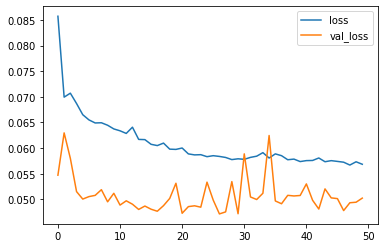

In [243]:
pyplot.plot(history.history['loss'], label='loss')
pyplot.plot(history.history['val_loss'], label='val_loss')
pyplot.legend()
pyplot.show()

In [244]:
y_predicted = model.predict(x_test)

In [245]:
y_predicted

array([[0.10367626],
       [0.10284345],
       [0.11338865],
       ...,
       [0.20017475],
       [0.21698172],
       [0.20334333]], dtype=float32)

In [246]:
df_eval = df_test[['date', 'PM10']]
df_eval['prediction'] = y_predicted

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [247]:
df_eval.head()

,date,PM10,prediction
10881,2018-11-04,0.099216,0.103676
10882,2018-11-05,0.076693,0.102843
10883,2018-11-06,0.184974,0.113389
10884,2018-11-07,0.191245,0.117876
10885,2018-11-08,0.150649,0.115135


In [334]:
df_inv_test = df_test[x_cols_t[-len(l)+1:]]
df_inv_test.columns = df_inv_test.columns.str.replace(f't-{DELTA+1}_', '')

In [336]:
df_inv_test["PM10"] = y_test
df_inv_test_real = pd.DataFrame()
df_inv_test_real[l] = scaler.inverse_transform(df_inv_test[l])
df_inv_test_real.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,PM10_var,longitud,latitud,day,weekday
0,0.263647,5.250000,15.416667,20.750000,21.031401,20.875000,1.628019,11.958333,7.791667,81.298007,12.950000,162.846618,1.762621,161.297101,-99.291705,19.365313,308.0,6.0
1,0.406884,23.416667,24.166667,47.375000,20.812802,16.541667,0.753623,15.791667,9.666667,77.634058,13.704167,162.566425,1.386534,142.564312,-99.291705,19.365313,309.0,0.0
2,0.400000,18.250000,23.083333,41.250000,20.152778,37.375000,0.722222,18.416667,11.083333,77.104167,14.093750,174.305556,1.644444,320.078804,-99.291705,19.365313,310.0,1.0
3,0.355556,14.875000,21.416667,36.458333,17.472222,38.581522,0.722222,14.000000,8.458333,77.312500,13.404167,182.750000,1.615278,98.679348,-99.291705,19.365313,311.0,2.0
4,0.326786,10.190476,17.761905,27.714286,14.724206,30.770833,0.869048,8.916667,4.291667,79.000000,12.256845,156.607143,1.326984,50.158781,-99.291705,19.365313,312.0,3.0


In [337]:
df_inv_test["PM10"] = y_predicted
df_inv_test_pred = pd.DataFrame()
df_inv_test_pred[l] = scaler.inverse_transform(df_inv_test[l])
df_inv_test_pred.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,PM10_var,longitud,latitud,day,weekday
0,0.263647,5.250000,15.416667,20.750000,21.031401,21.733212,1.628019,11.958333,7.791667,81.298007,12.950000,162.846618,1.762621,161.297101,-99.291705,19.365313,308.0,6.0
1,0.406884,23.416667,24.166667,47.375000,20.812802,21.572977,0.753623,15.791667,9.666667,77.634058,13.704167,162.566425,1.386534,142.564312,-99.291705,19.365313,309.0,0.0
2,0.400000,18.250000,23.083333,41.250000,20.152778,23.601893,0.722222,18.416667,11.083333,77.104167,14.093750,174.305556,1.644444,320.078804,-99.291705,19.365313,310.0,1.0
3,0.355556,14.875000,21.416667,36.458333,17.472222,24.465239,0.722222,14.000000,8.458333,77.312500,13.404167,182.750000,1.615278,98.679348,-99.291705,19.365313,311.0,2.0
4,0.326786,10.190476,17.761905,27.714286,14.724206,23.937917,0.869048,8.916667,4.291667,79.000000,12.256845,156.607143,1.326984,50.158781,-99.291705,19.365313,312.0,3.0


In [342]:
df_inv_test_real["prediction"] = df_inv_test_pred["PM10"]
df_inv_test_real.head()

,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,PM10_var,longitud,latitud,day,weekday,prediction
0,0.263647,5.250000,15.416667,20.750000,21.031401,20.875000,1.628019,11.958333,7.791667,81.298007,12.950000,162.846618,1.762621,161.297101,-99.291705,19.365313,308.0,6.0,21.733212
1,0.406884,23.416667,24.166667,47.375000,20.812802,16.541667,0.753623,15.791667,9.666667,77.634058,13.704167,162.566425,1.386534,142.564312,-99.291705,19.365313,309.0,0.0,21.572977
2,0.400000,18.250000,23.083333,41.250000,20.152778,37.375000,0.722222,18.416667,11.083333,77.104167,14.093750,174.305556,1.644444,320.078804,-99.291705,19.365313,310.0,1.0,23.601893
3,0.355556,14.875000,21.416667,36.458333,17.472222,38.581522,0.722222,14.000000,8.458333,77.312500,13.404167,182.750000,1.615278,98.679348,-99.291705,19.365313,311.0,2.0,24.465239
4,0.326786,10.190476,17.761905,27.714286,14.724206,30.770833,0.869048,8.916667,4.291667,79.000000,12.256845,156.607143,1.326984,50.158781,-99.291705,19.365313,312.0,3.0,23.937917


In [ ]:
df_inv_test_real

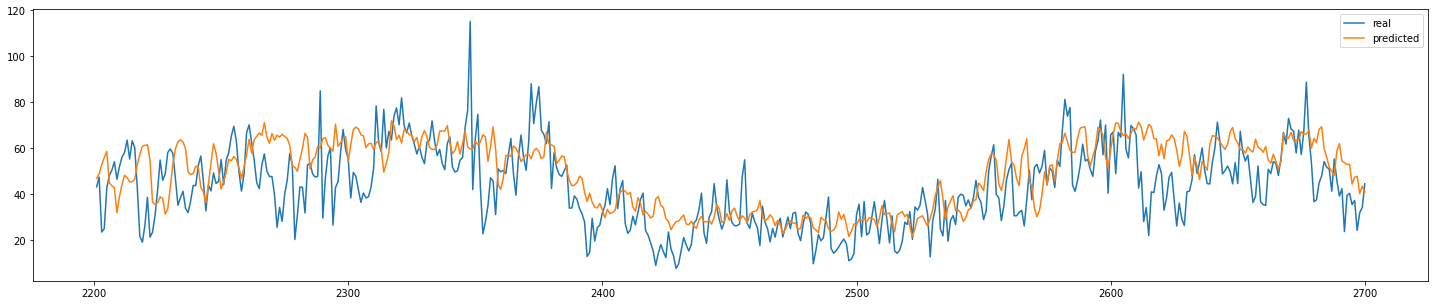

In [343]:
pyplot.figure(figsize=(25, 5))
pyplot.plot(df_inv_test_real["PM10"][-500:], label="real")
pyplot.plot(df_inv_test_real["prediction"][-500:], label="predicted")
pyplot.legend()
pyplot.show()

In [249]:
df_eval

,date,PM10,prediction
10881,2018-11-04,0.099216,0.103676
10882,2018-11-05,0.076693,0.102843
10883,2018-11-06,0.184974,0.113389
10884,2018-11-07,0.191245,0.117876
10885,2018-11-08,0.150649,0.115135
...,...,...,...
13587,2022-04-26,0.184463,0.237207
13588,2022-04-27,0.116963,0.239132
13589,2022-04-28,0.156985,0.200175
13590,2022-04-29,0.168670,0.216982


In [241]:
#df_eval["pollution"]
#df2 = df_eval.set_axis(['date', 'pollution', 'X', 'prediction', 'Z'], axis=1, inplace=False)
#df2

In [344]:
rmse = sqrt(mean_squared_error(df_inv_test_real["PM10"], df_inv_test_real["prediction"]))
print(f'Test RMSE: {rmse:.3f}')

Test RMSE: 12.752


In [264]:
model.save('pollution_model.h5')